# Start
This notebook should be as clean and compact as possible (for testing please create/copy a copy of this notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from skimage.segmentation import slic

from src.utils import load_image, downscale
from src.depth import estimate_depth, normalize_depth

In [2]:
img_name = "train"
ext = ".jpg"

orig_img = load_image("dataset/" + img_name + ext)

depth = normalize_depth(estimate_depth(orig_img)) * 100
img = downscale(orig_img, *depth.shape)
rgb_slic = slic(img, n_segments=1000, start_label=1, slic_zero=True)

cie_img = color.rgb2lab(img)

xFormers not available
xFormers not available


# Segment-Anything and KMeans

In [3]:
from src.segmentation import SegmentModel, obtain_all_objects, fill_with_superpixels, show_layers
from src.kmeans import get_optimal_k, assign2layers_kmeans

In [4]:
# lake parameters
mask_generator = SegmentModel(points_per_side=40).segment_anything 
object_masks = obtain_all_objects(mask_generator, img, img_r_thrd=0.95, n_thrd=10, ovlp_r_thrd=0.05, small_thrd=500) 


Iteration n=1: white pixel raito after segmentation = 0.68
Iteration n=2: white pixel raito after segmentation = 0.68
Iteration n=3: white pixel raito after segmentation = 0.71
Iteration n=4: white pixel raito after segmentation = 0.79
Iteration n=5: white pixel raito after segmentation = 0.76
Iteration n=6: white pixel raito after segmentation = 0.75
Iteration n=7: white pixel raito after segmentation = 0.77
Iteration n=8: white pixel raito after segmentation = 0.81
Iteration n=9: white pixel raito after segmentation = 0.79
Iteration n=10: white pixel raito after segmentation = 0.79
Iteration n=11: white pixel raito after segmentation = 0.79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


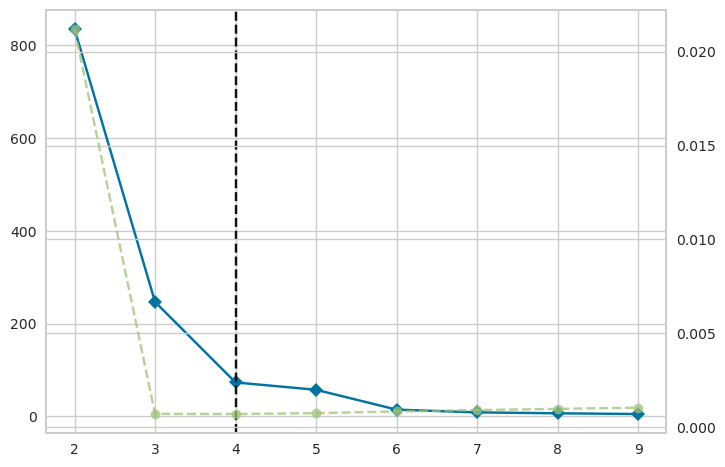

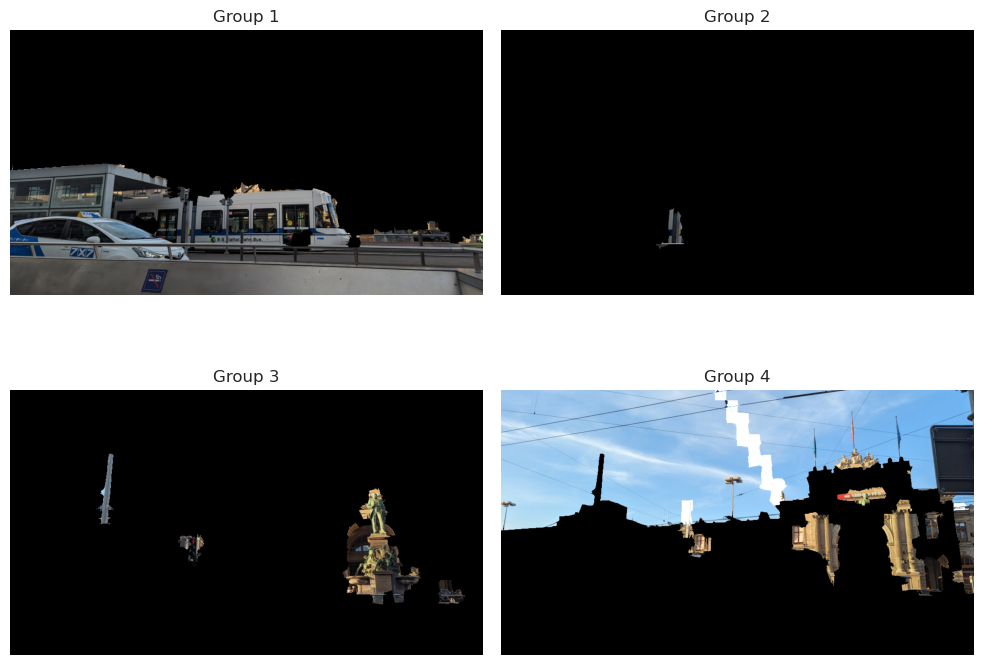

In [5]:
optimal_k = get_optimal_k(object_masks, depth)

object_masks = fill_with_superpixels(img, object_masks)

layers_idx, layers, layer_depth = assign2layers_kmeans(object_masks, depth, optimal_k)
show_layers(img, object_masks, layers_idx)

# Superpixels with Graph Opt

In [6]:
from scipy.ndimage import binary_fill_holes

from src.graph import RAG, merge_regions_until_done

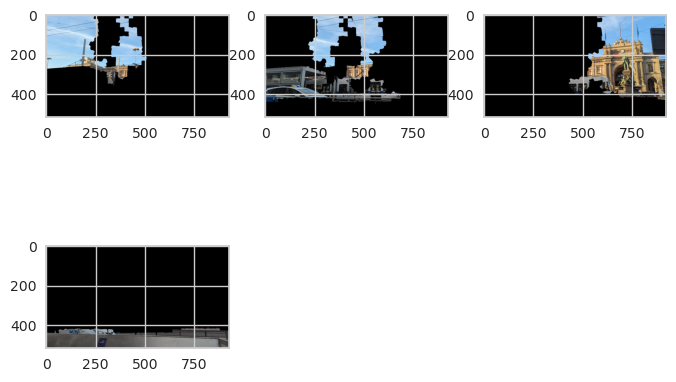

In [7]:
rag = RAG(img, depth, rgb_slic)

g, regions = merge_regions_until_done(rag.graph, rag.edge_nodes, optimal_k)

for i, reg in enumerate(regions):
    plt.subplot(231 + i)

    mask = binary_fill_holes(g.nodes[reg]['mask'])
    image = np.zeros(img.shape)
    image[mask] = img[mask]

    plt.imshow(image)

# Inpainting

In [ ]:
from src.inpaint import InpaintModel

In [ ]:
# # TODO: inpainting takes in a path rather than an image

# model = InpaintModel(input_img=img, resizeshape=(784,518))
# 
# mask = model.mask_filter_process(1, 5, 0.5, 'gaussian', True)
# layer_after_mask = model.inpaint_layer(1)
# 
# sample, mask = model.mask_re_segmentation(2, 50)